# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

## Исследовательский анализ данных

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [3]:
# Настройки вывода графиков
plt.rcParams["axes.titlesize"] = 16  # Размер шрифта
plt.rcParams["axes.titleweight"] = "bold"  # Толщина шрифта

In [4]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    raise FileNotFoundError(
        "Файл не найден по указанному пути: '/datasets/faces/labels.csv'"
    ) from e

In [5]:
labels.head(10)

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39

Датасет с данными загружен успешно

In [6]:
labels.info()
labels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

В датасете состоящем из 7591 строки и 2-х столбцов, отсутствуют пропуски.
Среднее значение возраста - 31 год, медианное - 29.

In [7]:
def hist_show(df, column, title, xlabel, ylabel, bins=100):
    if column not in df.columns:
        raise ValueError(f"Столбец '{column}' не найден в DataFrame")

    # Создаём фигуру и ось
    fig, ax = plt.subplots(figsize=(12, 6))

    # Строим гистограмму с KDE
    sns.histplot(df[column].dropna(), bins=bins, kde=True, color='skyblue', edgecolor='black', linewidth=1, ax=ax)

    # Оформление
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

    ax.set_xticks(range(0, 101, 10))
    ax.set_xticklabels([str(i) for i in range(0, 101, 10)])

    plt.tight_layout()
    plt.show()

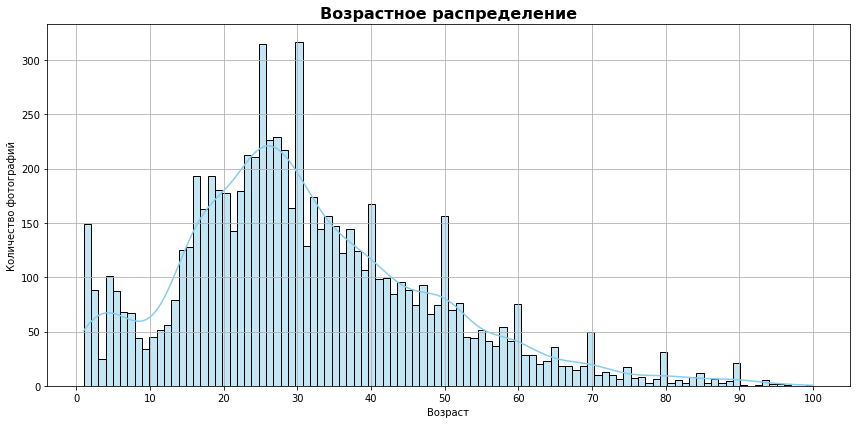

In [8]:
hist_show(
    labels,
    'real_age',
    'Возрастное распределение',
    'Возраст',
    'Количество фотографий'
)

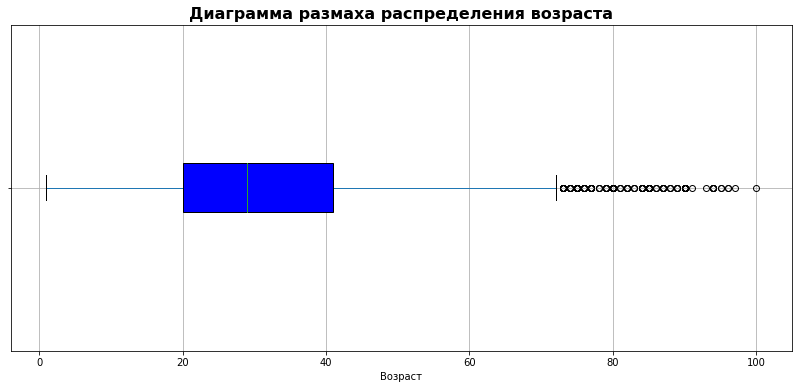

In [9]:
# Создаём фигуру и ось
fig, ax = plt.subplots(figsize=(14, 6))

# Строим boxplot по столбцу 'real_age'
labels.boxplot(
    column=['real_age'],
    vert=False,  # Горизонтально
    patch_artist=True,  # Заливка цветом
    boxprops=dict(facecolor="blue"),  # Цвет коробки
    grid=True,
    ax=ax  # Указание оси
)

# Заголовок
ax.set_title('Диаграмма размаха распределения возраста')
ax.set_yticklabels([])
ax.set_xlabel('Возраст')  # Добавим подпись оси X
plt.show()

- Наибольшее количество людей в возрасте от 20 до 40 лет;
- Количество людей старше 70 лет очень мало, не попадают в верхнюю границу усов.

In [10]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale=1/255.)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 7591 validated image filenames.


In [11]:
features, target = next(train_gen_flow)

In [12]:
def photo(age, features=features, target=target, photo_in_row=5):
    """
    Отображает до `photo_in_row` фотографий людей
    с возрастом в диапазоне (age - 5, age + 5).

    Параметры:
    -----------
    age : int или float
        Целевой возраст, вокруг которого выбираются фотографии.
    features : list или numpy.ndarray
        Список или массив изображений.
    target : list или numpy.ndarray
        Список или массив возрастов, соответствующих изображениям из features.
    photo_in_row : int, по умолчанию 5
        Количество фотографий, отображаемых в одной строке.

    Поведение:
    -----------
    - Выводит цветной текст с диапазоном возраста.
    - Показывает до `photo_in_row` изображений с возрастом в указанном диапазоне.
    - Если подходящих изображений нет, выводит предупреждение.
    """
    print('\033[1m', f'Возраст от {age - 5} до {age + 5}', '\033[0m')
    
    fig = plt.figure(figsize=(15, 8))
    
    count = 0
    
    for s in range(len(target)):
        if age - 5 <= target[s] < age + 5:
            ax = fig.add_subplot(1, photo_in_row, count + 1)
            ax.imshow(features[s])
            ax.set_title(f'Возраст: {int(target[s])}')
            ax.axis('off')
            count += 1
            if count == photo_in_row:
                break

    if count == 0:
        print("❗Нет изображений с подходящим возрастом. В данном батче")
    
    plt.tight_layout()
    plt.show()

 Возраст от 0 до 10 


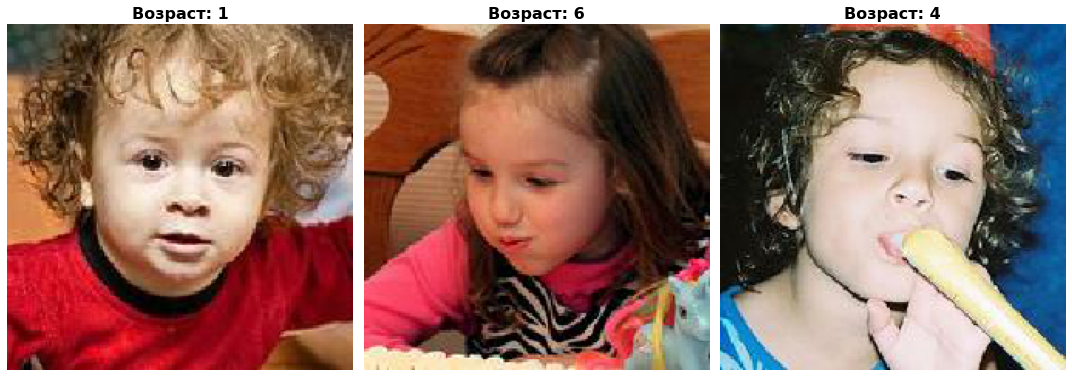

 Возраст от 10 до 20 


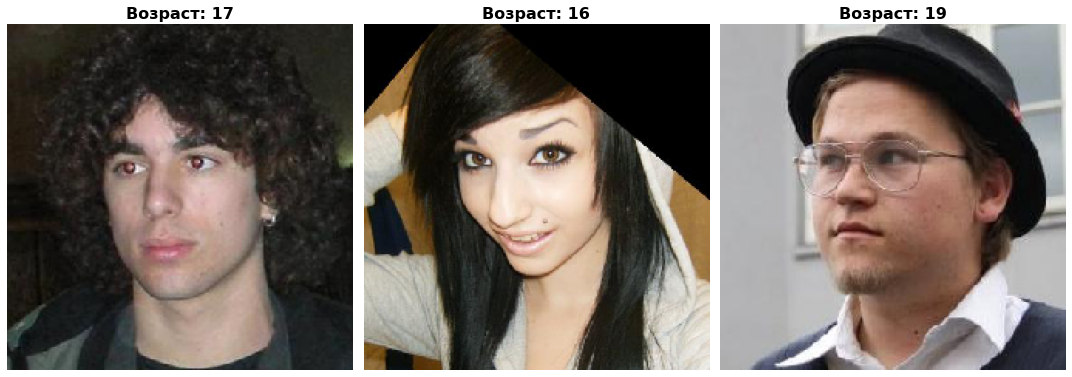

 Возраст от 20 до 30 


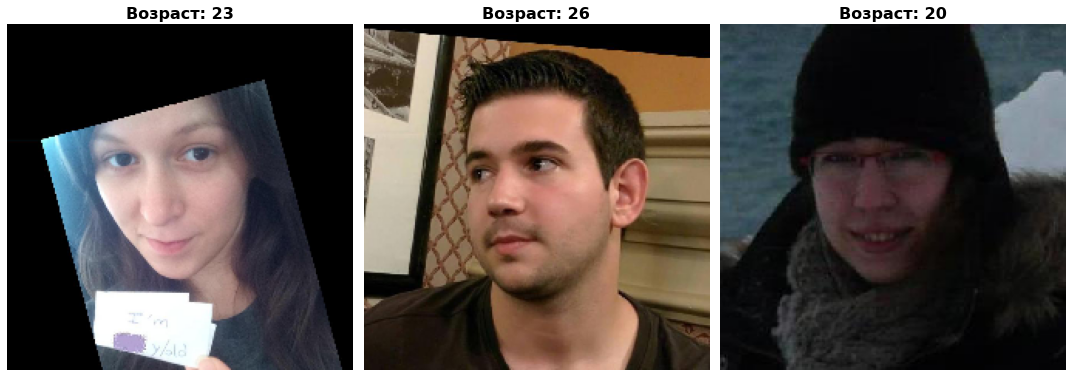

 Возраст от 30 до 40 


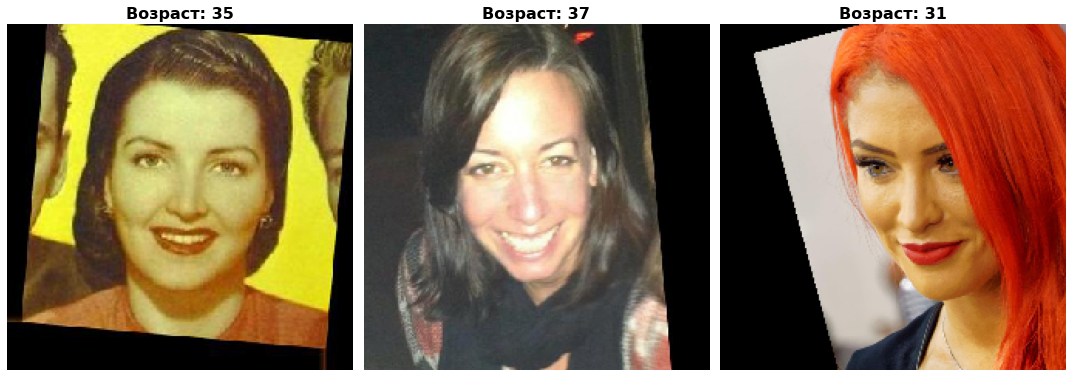

 Возраст от 40 до 50 


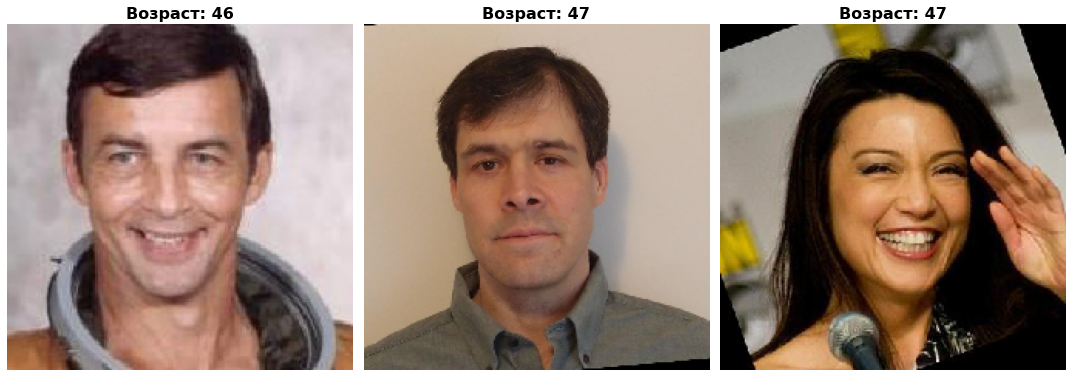

 Возраст от 50 до 60 


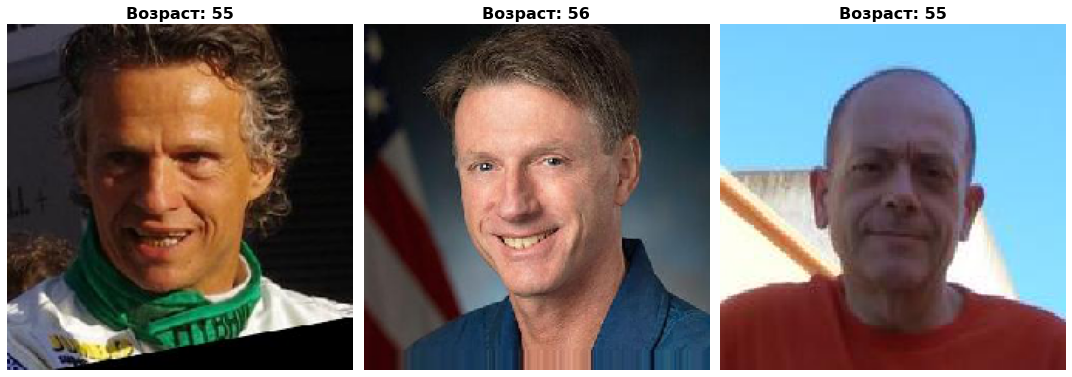

 Возраст от 60 до 70 


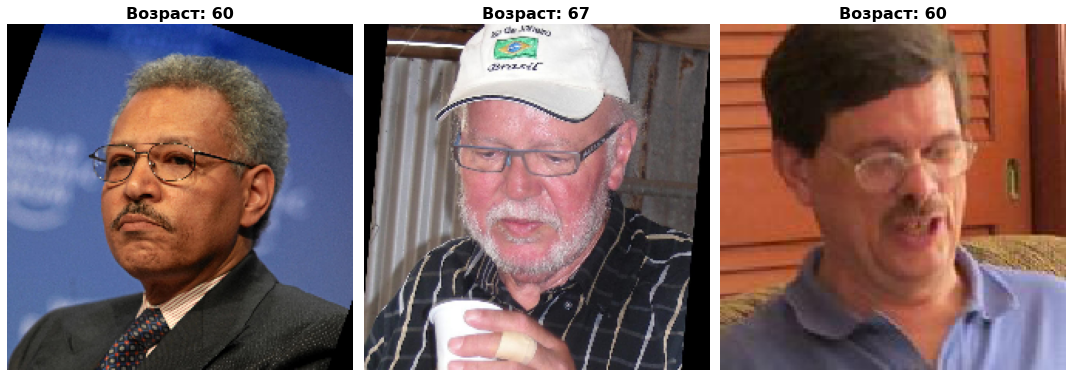

 Возраст от 70 до 80 


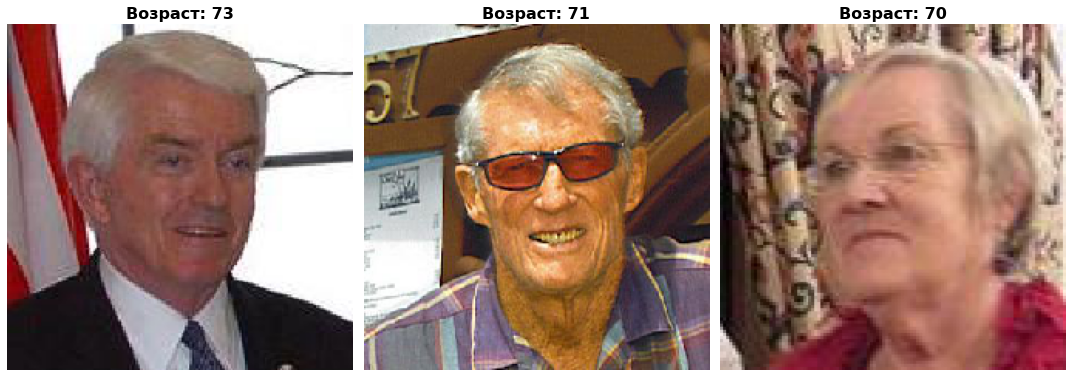

 Возраст от 80 до 90 
❗Нет изображений с подходящим возрастом. В данном батче


<Figure size 1080x576 with 0 Axes>

 Возраст от 90 до 100 


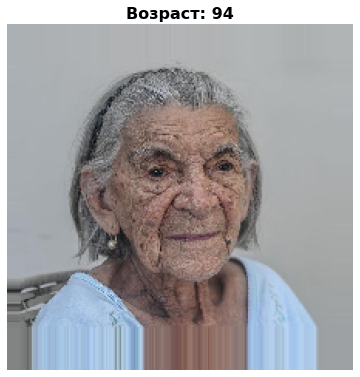

In [13]:
for i in range(5, 96, 10):
    photo(i, photo_in_row=3)

**Вывод:**

- Был загружен датасет с фотографиями людей разграниченные по возрасту.
- Диапазон возрастов - от 1 года до 100 лет.
- Наибольшее число людей в возрасте от 20 до 40 лет.
- Меньше всего людей в возрасте старше 70 лет.
- Диапазоны возрастов соотвествуют с фотографиями.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
# Импортирую некоторые библиотеки второй раз, т.к. необходимо чтобы ячейка с GPU работала вне зависимости от предыдущего кода
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Константы
BATCH_SIZE = 16
RANDOM_SEED = 42
TEST_SPLIT = 0.25


def load_train(path):
    """
    Загружает и подготавливает обучающий датасет с изображениями и метками возраста.

    Параметры:
    ----------
    path : str
        Путь к директории, содержащей файл 'labels.csv' и папку 'final_files/' с изображениями.

    Возвращает:
    ----------
    DirectoryIterator:
        Объект генератора изображений для обучения модели.
    """
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=TEST_SPLIT,
        horizontal_flip=True,
        rescale=1 / 255.
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='training',
        seed=RANDOM_SEED
    )

    return train_datagen_flow


def load_test(path):
    """
    Загружает и подготавливает валидационный датасет с изображениями и метками возраста.

    Параметры:
    ----------
    path : str
        Путь к директории, содержащей файл 'labels.csv' и папку 'final_files/' с изображениями.

    Возвращает:
    ----------
    DirectoryIterator:
        Объект генератора изображений для валидации модели.
    """

    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=TEST_SPLIT,
        rescale=1. / 255
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='validation',
        seed=RANDOM_SEED
    )

    return test_datagen_flow


def create_model(input_shape):
    """
    Создаёт и компилирует модель на основе предобученной ResNet50 для задачи регрессии возраста.

    Параметры:
    ----------
    input_shape : tuple
        Размер входного изображения (высота, ширина, каналы), например (224, 224, 3).

    Возвращает:
    ----------
    keras.Model:
        Скомпилированная модель Keras.
    """

    backbone = ResNet50(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Обучает модель с использованием обучающих и валидационных данных, включая контроль переобучения.

    Параметры:
    ----------
    model : keras.Model
        Модель, которую нужно обучить.
    train_data : DirectoryIterator
        Генератор обучающих данных.
    test_data : DirectoryIterator
        Генератор валидационных данных.
    batch_size : int, optional
        Размер батча (по умолчанию None, берётся из генератора).
    epochs : int, optional
        Количество эпох обучения (по умолчанию 20).
    steps_per_epoch : int, optional
        Количество шагов на эпоху (по умолчанию равно длине train_data).
    validation_steps : int, optional
        Количество шагов валидации (по умолчанию равно длине test_data).

    Возвращает:
    ----------
    keras.Model:
        Обученная модель с лучшими весами по валидации.
    """

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    # Сохранение лучшей модели + контроль от переобучения
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=2
    )
    
    # Оценка модели
    test_loss, test_mae = model.evaluate(test_data, verbose=2)
    print(f"Test MAE: {test_mae:.2f}")

    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 73s - loss: 221.6030 - mae: 10.7664 - val_loss: 394.4471 - val_mae: 14.8373
Epoch 2/20
356/356 - 40s - loss: 92.2311 - mae: 7.2290 - val_loss: 171.0239 - val_mae: 9.9612
Epoch 3/20
356/356 - 40s - loss: 63.5015 - mae: 6.0399 - val_loss: 87.9690 - val_mae: 6.8424
Epoch 4/20
356/356 - 40s - loss: 46.4958 - mae: 5.1751 - val_loss: 79.0295 - val_mae: 6.3815
Epoch 5/20
356/356 - 41s - loss: 35.6414 - mae: 4.5518 - val_loss: 71.7968 - val_mae: 6.4145
Epoch 6/20
356/356 - 40s - loss: 26.9725 - mae: 3.9585 - val_loss: 70.9979 - val_mae: 6.3971
Epoch 7/20
356/356 - 39s - loss: 23.0669 - mae: 3.6431 - val_loss: 112.2307 - val_mae: 7.9078
Epoch 8/20
356/356 - 40s - loss: 20.1676 - mae: 3.4274 - val_loss: 67.2961 - val_mae: 6.1295
Epoch 9/20
356/356 - 41s - loss: 16.3236 - mae: 3.0718 - val_loss: 66.9515 - val_mae: 6.0385
Epoch 10/20
356/356 - 39s - loss: 15.6210 - mae: 3.0263 - val_loss: 70.0429 - val_mae: 6.1519
Epoch 11/20
356/356 - 39s - loss: 15.0366 - mae: 2.9774 - val_loss: 70.1655 - val_mae: 6.4236
Epoch 12/20
356/356 - 39s - loss: 13.1876 - mae: 2.7670 - val_loss: 85.8869 - val_mae: 7.1546
Epoch 13/20
356/356 - 39s - loss: 12.9166 - mae: 2.7495 - val_loss: 72.5854 - val_mae: 6.2247
Epoch 14/20
356/356 - 39s - loss: 13.5212 - mae: 2.7861 - val_loss: 74.2521 - val_mae: 6.6069

119/119 - 10s - loss: 66.9515 - mae: 6.0385
Test MAE: 6.04

```

## Анализ обученной модели

- Модель построена на основе ResNet50, а в качестве метрики использовалась MAE.
- Модель показала хороший результат - 6.0385 при 20 эпохах.
- Алгоритмом оптимизации выступала адаптивная оценка момента (Adam) с learning_rate=0.0001.
- Получена возможность определять возраст покупателей с ошибкой примерно в 6 лет.
- Модель можно внедрять в магазины для решения первой задачи. Это анализ покупок и возможность предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
- Для решения второй задачи классификации (о продаже алкоголя) модель не подходит. Следует разметить набор данных на фотографии на которых людям 18 и более лет и менее 18 лет. А потом использовать модель классификации, пример кода данной модели(

    def create_model(input_shape):

        backbone = ResNet50(
            weights='imagenet',
            input_shape=input_shape,
            include_top=False
        )

        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))  # Сигмоида для бинарной классификации

        optimizer = Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return model
) 